In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import iqr

Set IQR cut-off

In [199]:
# SD Outlier cutoff:
#   - 1.50 produces ~ 98/02 split
#   - 1.08 produces ~ 90/10 split
#   - 0.87 produces ~ 80/20 split

oliqr = 1.08

Load Main Dataset (with dirty date labels)

In [200]:
df = pd.read_csv('decades-MusicBrainz.csv')
df.dropna(axis=0, subset=['Artist','Title','Lyric'], how='any', inplace=True) # drop unusable
df.drop_duplicates(subset=['Artist','Title'])
df.sample()

,Title,Artist,Genres,Lyric,Decade,Year,Popularity
31795,Mack The Knife,Louis Armstrong,Jazz,"Oh, the shark, babe, has such teeth, dear\nAnd...",2010,2017,6.9


How many songs do most artists have in the dataset?

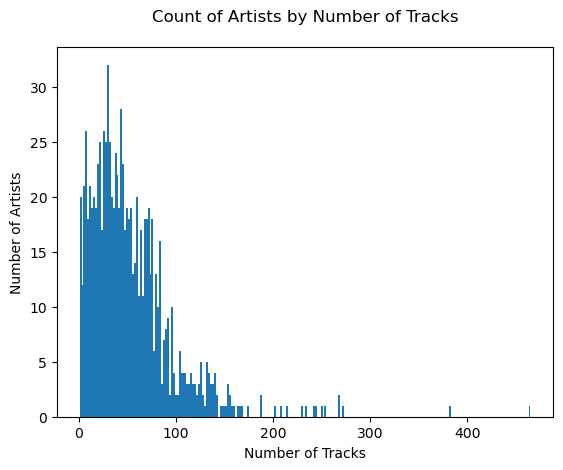

In [201]:
tracks = df.groupby('Artist')['Title'].count().reset_index() \

tracks.plot(
    kind='hist', bins=(tracks['Title'].max() - tracks['Title'].min()) // 2, 
    title = 'Count of Artists by Number of Tracks\n', legend=False
)
plt.xlabel('Number of Tracks')
plt.ylabel('Number of Artists')
plt.show()

Caculate means, standard deviations, and IQR

In [202]:
meansd = df.groupby('Artist', as_index=False)['Year'].agg({'mean_year': 'mean', 'std_year': 'std', 'iqr_year': iqr})
meansd['low_year'] = meansd['mean_year'] - (meansd['iqr_year'] * oliqr)
meansd['high_year'] = meansd['mean_year'] + (meansd['iqr_year'] * oliqr)
meansd.sample(2)

,Artist,mean_year,std_year,iqr_year,low_year,high_year
385,Jamie Foxx,1989.477273,16.512840,27.0,1960.317273,2018.637273
557,MercyMe,1991.663043,17.281939,26.5,1963.043043,2020.283043


Integrate means, sdevs, and IQR into the original dataframe

In [203]:
stats = df.merge(meansd, how='left', on='Artist')
stats['Outlier'] = stats.apply(lambda x: x['Year']<x['low_year'] or x['Year'] > x['high_year'], axis=1)

# Create dataframe containing only outliers
train = stats[~stats['Outlier']]
test = stats[stats['Outlier']]

In [204]:
print(f'Total Rows: {len(df)}')
print(f'Outliers: {len(test)}')
print(f'Training Set: {len(df)-len(test)} ({1-len(test)/len(df):.2%})')

Total Rows: 50049
Outliers: 4964
Training Set: 45085 (90.08%)


Plot cut-offs

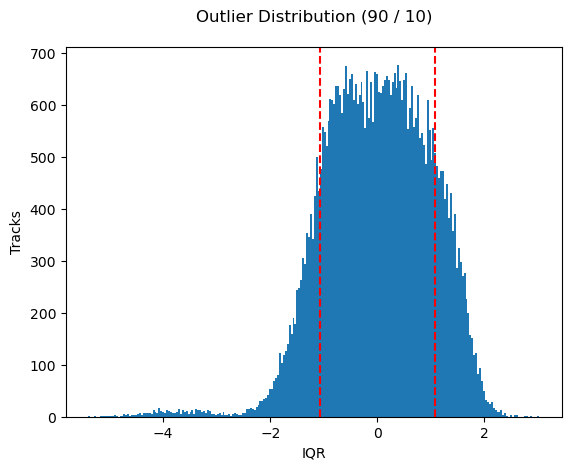

In [205]:
olpct = (len(test)/len(df)) * 100
                                
devdf = stats.loc[:, ['Year','mean_year','std_year']]
devdf['devs'] = (devdf['Year'] - devdf['mean_year']) / devdf['std_year']

devdf['devs'].plot(
    kind='hist', bins=(tracks['Title'].max() - tracks['Title'].min()) // 2, 
    title = f'Outlier Distribution ({100-olpct:.0f} / {olpct:.0f})\n', legend=False
)
plt.axvline(x=-oliqr, color='red', linestyle = '--')
plt.axvline(x=oliqr, color='red', linestyle = '--')
plt.xlabel('IQR')
plt.ylabel('Tracks')
plt.show()

View the test (outliers) dataset

In [206]:
test.sample(20)

,Title,Artist,Genres,Lyric,Decade,Year,Popularity,mean_year,std_year,iqr_year,low_year,high_year,Outlier
17119,King For A Day,Faith No More,Rock Alternativo; Heavy Metal; Rock,"It is not a good day, if you are not looking g...",2010,2018,2.2,1989.100000,20.464686,21.00,1966.420000,2011.780000,True
22761,Convict,Queensrÿche,Heavy Metal; Rock; Progressivo,instrumental,2010,2011,1.0,1988.326316,15.885523,20.00,1966.726316,2009.926316,True
32878,Starlight,Kara,K-Pop/K-Rock; J-Pop/J-Rock,Jakgo nune ttuiji moshaessdeon\nNega nal arabw...,1900,1905,0.0,1985.897959,20.516502,30.00,1953.497959,2018.297959,True
3663,Cross My Heart and Hope to Die,Elvis Presley,Rockabilly; Romântico; Rock,(Words & music by Wayne - Weisman)\nI can expl...,2010,2017,23.1,1979.002618,20.294356,28.00,1948.762618,2009.242618,True
7318,Silent Night,Kenny Chesney,Country,"Silent night,\nHoly night,\nAll is calm,\nAll ...",1950,1953,0.0,1993.345679,16.679449,24.00,1967.425679,2019.265679,True
30882,Someone To Watch Over Me,Ray Conniff,Instrumental,There's a saying old\nSays that love is blind\...,2010,2012,0.0,1975.857143,20.645169,27.50,1946.157143,2005.557143,True
32576,Almost Persuaded,Etta Jones,Jazz; Blues,Last night all alone in a barroom\nMet a girl ...,1900,1901,0.0,1972.346154,25.060620,28.75,1941.296154,2003.396154,True
48826,Ave Maria,Michael Bolton,Romântico,"Gratia plena\nMaria, gratia plena\nMaria, grat...",1890,1890,3.6,1982.950495,20.058602,29.00,1951.630495,2014.270495,True
2692,Mr. Happy,Prince,R&B; Black Music; Funk,"{""Microphone check"" sample repeated in song}\n...",2010,2016,2.8,1988.000000,17.292808,21.00,1965.320000,2010.680000,True
41054,Today,Lagwagon,Punk Rock,As you expect here as the keys\nSo come and go...,1960,1964,0.0,1990.973333,18.566879,19.50,1969.913333,2012.033333,True


In [207]:
train.to_csv('years_train.csv', index=False)
test.to_csv('years_test.csv', index=False)